In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from dateutil import tz
from metpy.plots import USCOUNTIES

%matplotlib inline

Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [2]:
# Read in Shapefile
cat_gdf = geopandas.read_file('data/day2otlk_cat.shp')

In [3]:
# Set Coordinate Reference System for the map
map_crs = ccrs.Mercator()

# Set Coordinate Reference System from the Shapefile Data
data_crs = ccrs.PlateCarree()

In [4]:
# Get time data
start_time = cat_gdf['VALID'][0]
end_time = cat_gdf['EXPIRE'][0]

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

def convert_datetime_from_spc_to_local(string):
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

def get_valid_day(string):
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

valid_day_start = get_valid_day(start_time)
valid_day_end = get_valid_day(end_time)

In [5]:
# Set colors
# For SPC outlooks: "2" references a "General Thunderstorm" risk, "3" a Marginal Risk, "4" a Slight Risk, and so on

cat_plot_colors = {'General Thunderstorms Risk': 'palegreen',
                   'Marginal Risk': 'green',
                   'Slight Risk': 'yellow',
                   'Enhanced Risk': 'brown',
                   'Moderate Risk': 'red',
                   'High Risk': 'magenta'}

# cat_plot_colors = {
#     '15% Any Severe Risk': 'yellow',
#     '30% Any Severe Risk': 'orange'
# }

# Generate legend patches
legend_patches = []
for val in cat_plot_colors.keys():
   patch = mpatches.Patch(color=cat_plot_colors[val], label=val)
   legend_patches.append(patch)

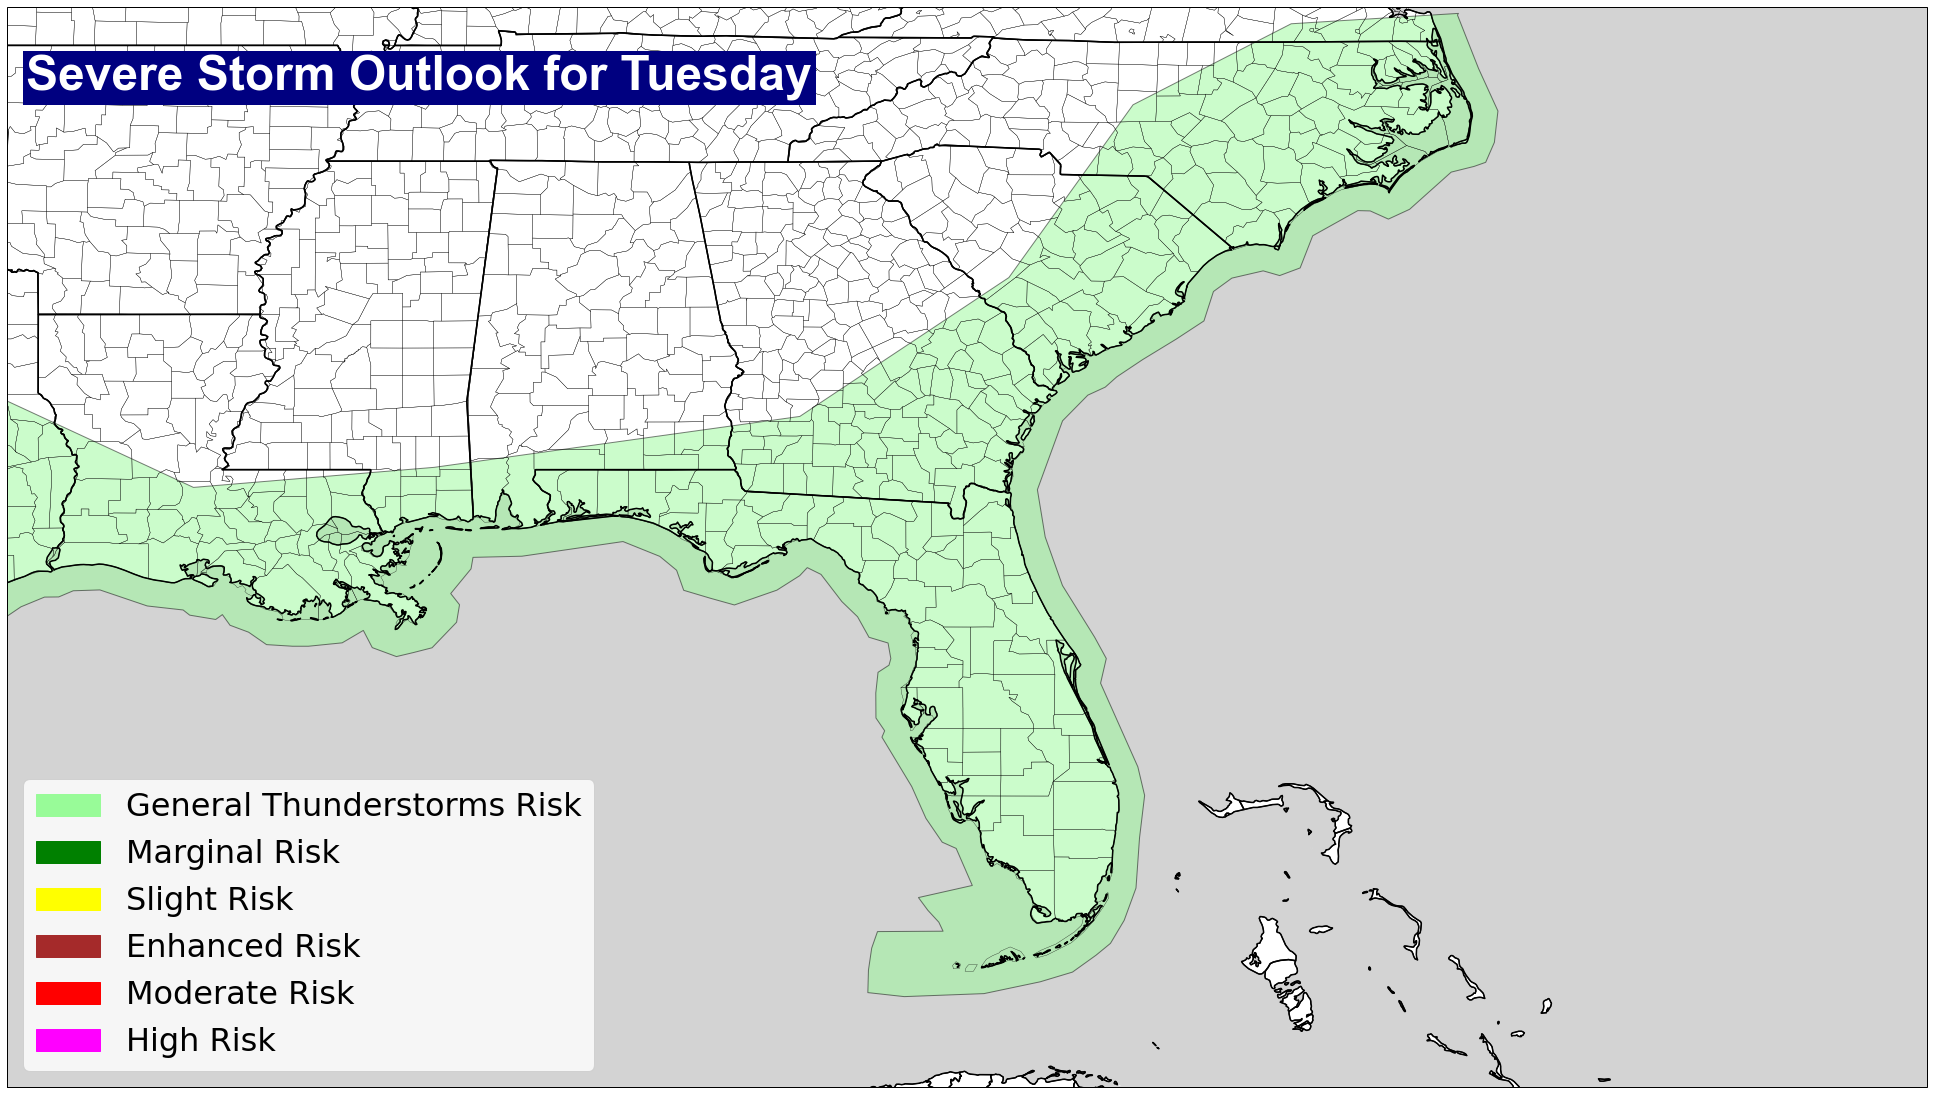

In [6]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=data_crs)

ax.set_extent([-89, -75, 23, 37], data_crs)
ax.set_adjustable('datalim')

# Setup borders (states, countries, coastlines, etc)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='black', zorder=5, linewidth=0.3)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.5, zorder=10)

for key in cat_plot_colors.keys():
    geometries = cat_gdf[cat_gdf['LABEL2'] == key]
    # Check to see if there an area outlooked at all. If so, add the polygons to the map.
    if len(geometries) > 0:
        ax.add_geometries(geometries['geometry'], crs=data_crs,
                          facecolor=cat_plot_colors[key], edgecolor='black',
                          alpha=0.5)

# Plot the legend
plt.legend(handles=legend_patches, fontsize=32, loc='lower left',)
        
# Set title
ax.set_title(f'Severe Storm Outlook for {valid_day_start}', loc='left', 
             ha='left', va='top', fontsize=48, color='white', 
             fontweight='bold', fontname='Arial', y=0.95, x=0.01, zorder=11,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'spc'
plt.savefig(f'{graphics_dir}/categorical_day2.png', dpi=72)

<Figure size 432x288 with 0 Axes>